# Prophet 삼성전자 주가 예측

## #01. 준비작업

### [1] 패키지 가져오기

`yfinance` 패키지가 필요하다.

In [93]:
import warnings
warnings.filterwarnings(action='ignore')
import logging
from hossam.util import *
from hossam.plot import *
from hossam.timeserise import *

import datetime as dt
import yfinance as yf
from pandas import date_range
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from pandas import concat

### [2] 데이터 가져오기

오늘을 기준으로 1년간의 주가 데이터를 일단위로 수입

#### (1) 오늘로부터 3년 전 날짜

In [119]:
today = dt.datetime.now()
start = today - dt.timedelta(days=365*3)
start_day = start.strftime("%Y-%m-%d")
start_day

'2021-03-15'

#### (2) 1년간의 삼성전자 주가 데이터 수집

In [120]:
origin = yf.download('108320.KS', start = start_day)
print("수집된 데이터 크기:", len(origin))
my_pretty_table(origin.head())

[*********************100%%**********************]  1 of 1 completed

수집된 데이터 크기: 740
+---------------------+--------+--------+-------+---------+-------------+----------+
| Date                |   Open |   High |   Low |   Close |   Adj Close |   Volume |
|---------------------+--------+--------+-------+---------+-------------+----------|
| 2021-03-15 00:00:00 |  68800 |  70700 | 68300 |   70000 |     62585.7 |   176597 |
| 2021-03-16 00:00:00 |  72000 |  76300 | 70700 |   73800 |     65983.2 |   507516 |
| 2021-03-17 00:00:00 |  74200 |  75600 | 71700 |   74100 |     66251.4 |   219470 |
| 2021-03-18 00:00:00 |  74100 |  74500 | 72400 |   72700 |     64999.7 |   140370 |
| 2021-03-19 00:00:00 |  71200 |  74000 | 71200 |   73600 |     65804.4 |   148213 |
+---------------------+--------+--------+-------+---------+-------------+----------+


## #02. 데이터 전처리

### [1] Prophet이 요구하는 데이터 형식으로 만들기

#### (1) 필요한 종속변수만 추출

In [121]:
df1 = origin[['Close']]
df1.head()

,Close
Date,
2021-03-15,70000.0
2021-03-16,73800.0
2021-03-17,74100.0
2021-03-18,72700.0
2021-03-19,73600.0


#### (2) 인덱스 해제

In [122]:
df2 = df1.reset_index()
df2.head()

,Date,Close
0,2021-03-15,70000.0
1,2021-03-16,73800.0
2,2021-03-17,74100.0
3,2021-03-18,72700.0
4,2021-03-19,73600.0


#### (3) 컬럼명 변경

In [123]:
df3 = df2.rename(columns = {'Date': 'ds', 'Close': 'y'})
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 740 entries, 0 to 739
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      740 non-null    datetime64[ns]
 1   y       740 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 11.7 KB


## #03. 탐색적 데이터 분석

### [1] 1년간 최고가와 최저가 확인

In [124]:
max_y = origin['Close'].max()
min_y = origin['Close'].min()
max_y, min_y

(167300.0, 69800.0)

### [2] 최고가를 기록한 날짜와 최저가를 기록한 날짜만 필터링

In [125]:
minmax = origin.query("Close == @max_y | Close == @min_y")
minmax 

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-12-30,159600.0,168800.0,158600.0,167300.0,154663.031250,422504
2023-01-02,71100.0,72400.0,69600.0,69800.0,68399.328125,87595


### [3] 날짜만 추출

In [126]:
min_date = minmax.index[0]
max_date = minmax.index[1]
min_date, max_date

(Timestamp('2021-12-30 00:00:00'), Timestamp('2023-01-02 00:00:00'))

### [4] 시각화

In [127]:
def addon(ax):
    sb.scatterplot(data=minmax, x=minmax.index, y='Close', color='red', s=150, marker='o', ax=ax)
    ax.text(min_date, min_y, '[최저점]\n날짜: %s\n종가: %d' % (min_date, min_y), fontsize = 12, color='red')
    ax.text(max_date, max_y, '[최고점]\n날짜: %s\n종가: %d' % (max_date, max_y), fontsize = 12, color='red')

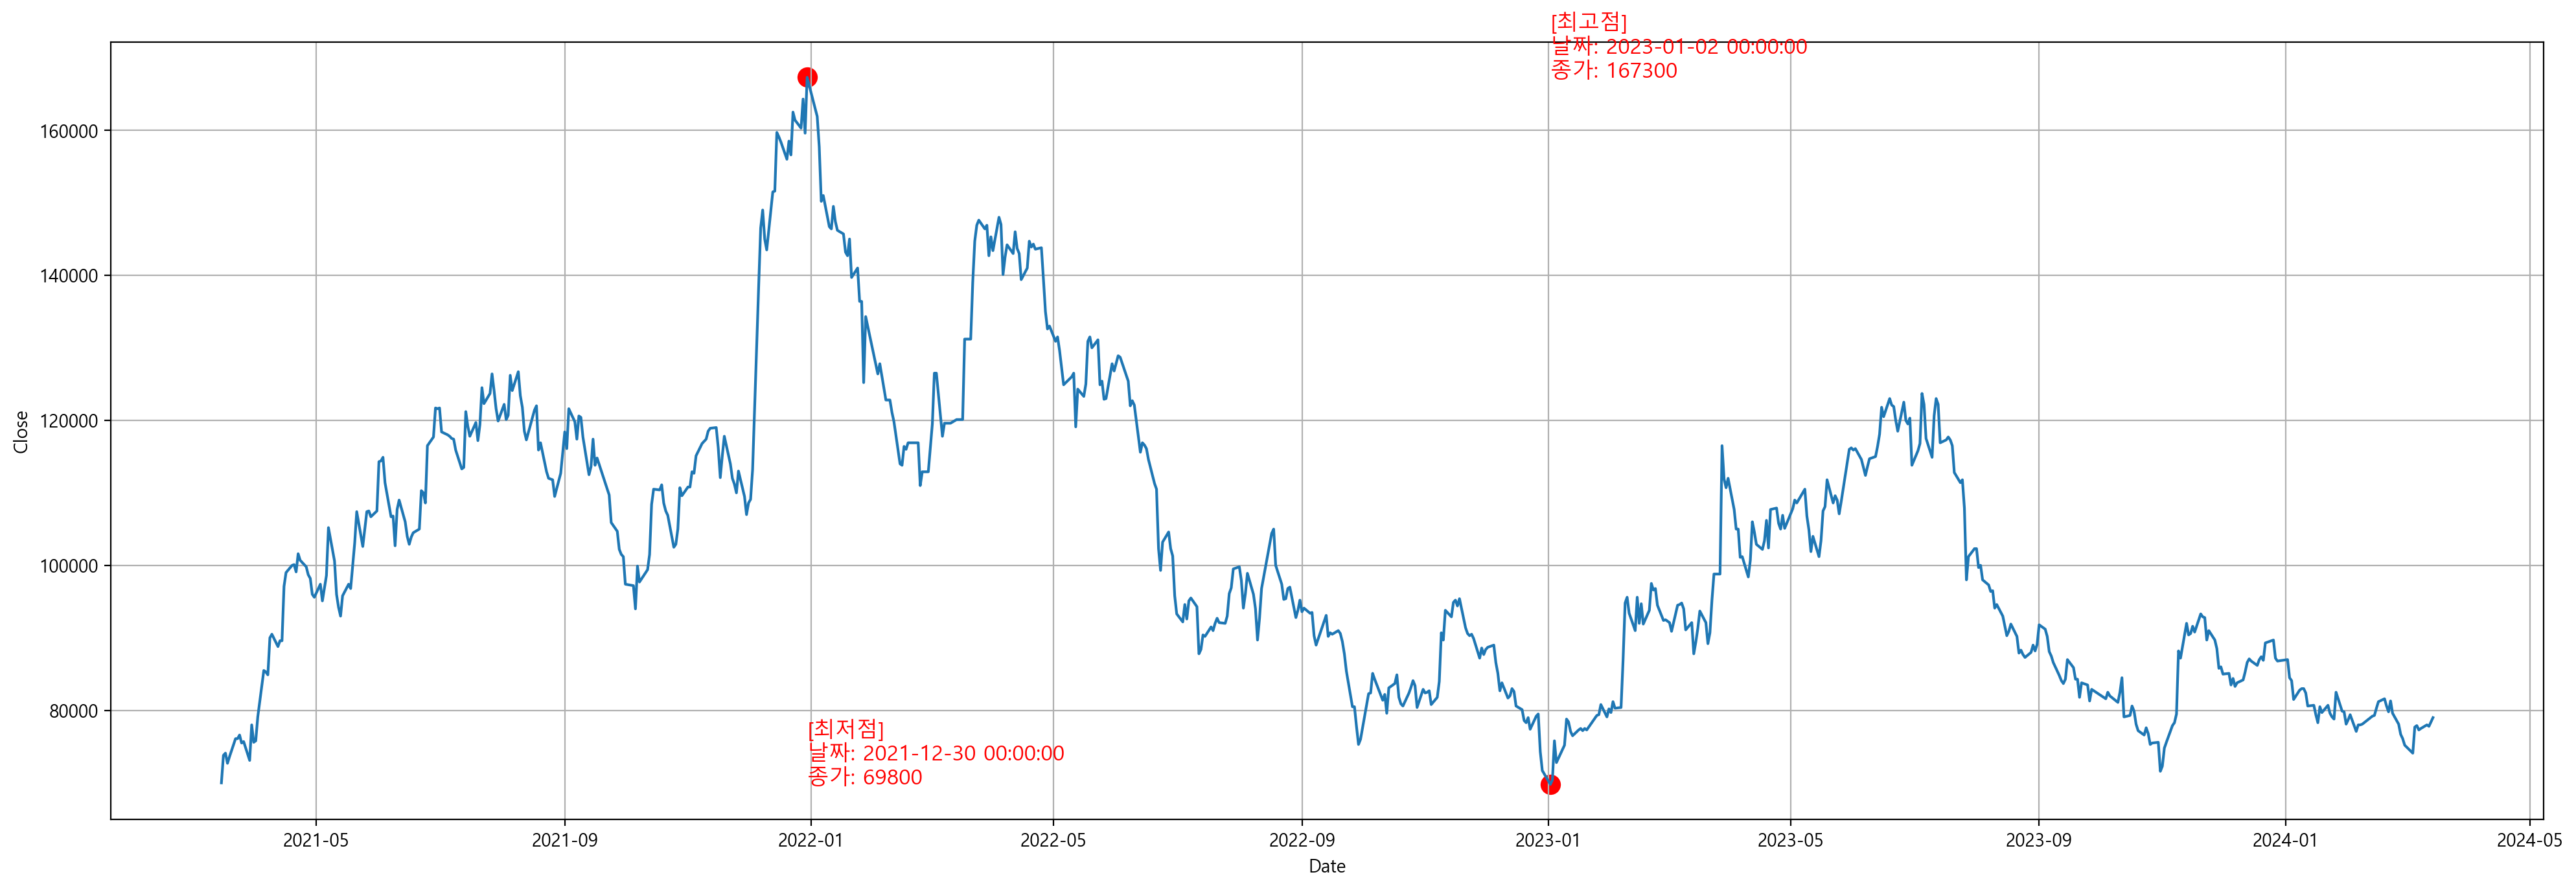

In [128]:
my_lineplot(origin, xname=origin.index, yname='Close', figsize=(20,7), dpi=200, callback=addon)

## #03. 데이터 전처리

### [1] 기간내 전체 날짜 생성

In [129]:
dates = date_range(start = origin.index.min(), end=origin.index.max(), freq='1D')
dates

DatetimeIndex(['2021-03-15', '2021-03-16', '2021-03-17', '2021-03-18',
               '2021-03-19', '2021-03-20', '2021-03-21', '2021-03-22',
               '2021-03-23', '2021-03-24',
               ...
               '2024-03-05', '2024-03-06', '2024-03-07', '2024-03-08',
               '2024-03-09', '2024-03-10', '2024-03-11', '2024-03-12',
               '2024-03-13', '2024-03-14'],
              dtype='datetime64[ns]', length=1096, freq='D')

### [2] 전체 날짜에 대한 데이터 프레임

In [130]:
df1 = DataFrame({
    'Close': 0, 
}, index=dates)

df1

,Close
2021-03-15,0
2021-03-16,0
2021-03-17,0
2021-03-18,0
2021-03-19,0
...,...
2024-03-10,0
2024-03-11,0
2024-03-12,0
2024-03-13,0


### [3] 종가만 병합

In [131]:
df1['Close'] = origin['Close']
df1.head(20)

,Close
2021-03-15,70000.0
2021-03-16,73800.0
2021-03-17,74100.0
2021-03-18,72700.0
2021-03-19,73600.0
2021-03-20,NaN
2021-03-21,NaN
2021-03-22,76100.0
2021-03-23,76100.0
2021-03-24,76600.0


### [4] 결측치를 갖는 날짜만 별도로 분리 (=주말)

In [132]:
df2 = df1.fillna(0)
df_tmp = df2[df2['Close'] == 0]
df_tmp['holiday'] = 'holiday'
holiday_df = df_tmp.drop('Close', axis=1)
holiday_df.reset_index(drop=False, inplace=True)
holiday_df.rename(columns={'index': 'ds'}, inplace=True)
holiday_df


,ds,holiday
0,2021-03-20,holiday
1,2021-03-21,holiday
2,2021-03-27,holiday
3,2021-03-28,holiday
4,2021-04-03,holiday
...,...,...
351,2024-03-01,holiday
352,2024-03-02,holiday
353,2024-03-03,holiday
354,2024-03-09,holiday


### [4] 결측치 대체

In [133]:
df2 = df1.fillna(method='ffill')
df2.head(20)

,Close
2021-03-15,70000.0
2021-03-16,73800.0
2021-03-17,74100.0
2021-03-18,72700.0
2021-03-19,73600.0
2021-03-20,73600.0
2021-03-21,73600.0
2021-03-22,76100.0
2021-03-23,76100.0
2021-03-24,76600.0


In [134]:
df3 = df2.reset_index()
df3

,index,Close
0,2021-03-15,70000.0
1,2021-03-16,73800.0
2,2021-03-17,74100.0
3,2021-03-18,72700.0
4,2021-03-19,73600.0
...,...,...
1091,2024-03-10,77500.0
1092,2024-03-11,78000.0
1093,2024-03-12,77800.0
1094,2024-03-13,78400.0


In [135]:
df4 = df3.rename(columns={'index': 'ds', 'Close': 'y'})
df4

,ds,y
0,2021-03-15,70000.0
1,2021-03-16,73800.0
2,2021-03-17,74100.0
3,2021-03-18,72700.0
4,2021-03-19,73600.0
...,...,...
1091,2024-03-10,77500.0
1092,2024-03-11,78000.0
1093,2024-03-12,77800.0
1094,2024-03-13,78400.0


## #04. 시계열 분석 수행

### [1] 기본 설정만으로 진행

In [136]:
params = {
    'changepoint_prior_scale':[0.1, 0.5, 1.0],
    'seasonality_prior_scale':[0.1, 0.5, 1.0],
    'seasonality_mode':['additive', 'multiplicative'],
    'weekly_seasonality':[True, False],
    'daily_seasonality':[True, False],
    'yearly_seasonality':[True, False],
    'holidays': [holiday_df]
}



In [137]:
def set_hollydays(m):
    m.add_country_holidays(country_name='KR')

In [138]:
train, test = my_timeseries_split(df4)
train.shape, test.shape

((876, 2), (220, 2))

In [139]:

logger = logging.getLogger("cmdstanpy")
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.CRITICAL)

size: 220
size: 220
size: 220
size: 220
size: 220
size: 220
size: 220
size: 220
size: 220
size: 220
size: 220
size:size: 220
 220
size: 220
size: 220
size: 220
size: 220
size: 220
size: 220
size: 220
size: 220
size: 220
size: 220
size: 220
size: 220
size: 220
size: 220
size: 220
size: 220
size: 220
size: 220
size: 220
size: 220
size: 220
size: 220
size: 220
size: 220
size: 220
size: 220
size: 220
size: 220
size: 220
size: 220
size: 220
size: 220
size: 220
size: 220
size: 220
size: 220
size: 220
size: 220
size: 220
size: 220
size: 220
size: 220
size: 220
size: 220
size: 220
size: 220
size: 220
size: 220
size: 220
size: 220
size: 220
size: 220
size: 220
size: 220
size: 220
size: 220
size: 220
size: 220
size: 220
size: 220
size: 220
size: 220
size: 220
size: 220
size: 220
size: 220
size: 220
size: 220
size: 220
size: 220
size: 220
size: 220
size: 220
size: 220
size: 220
size: 220
size: 220
size: 220
size: 220
size: 220
size: 220
size: 220
size: 220
size: 220
size: 220
size: 220
size: 220


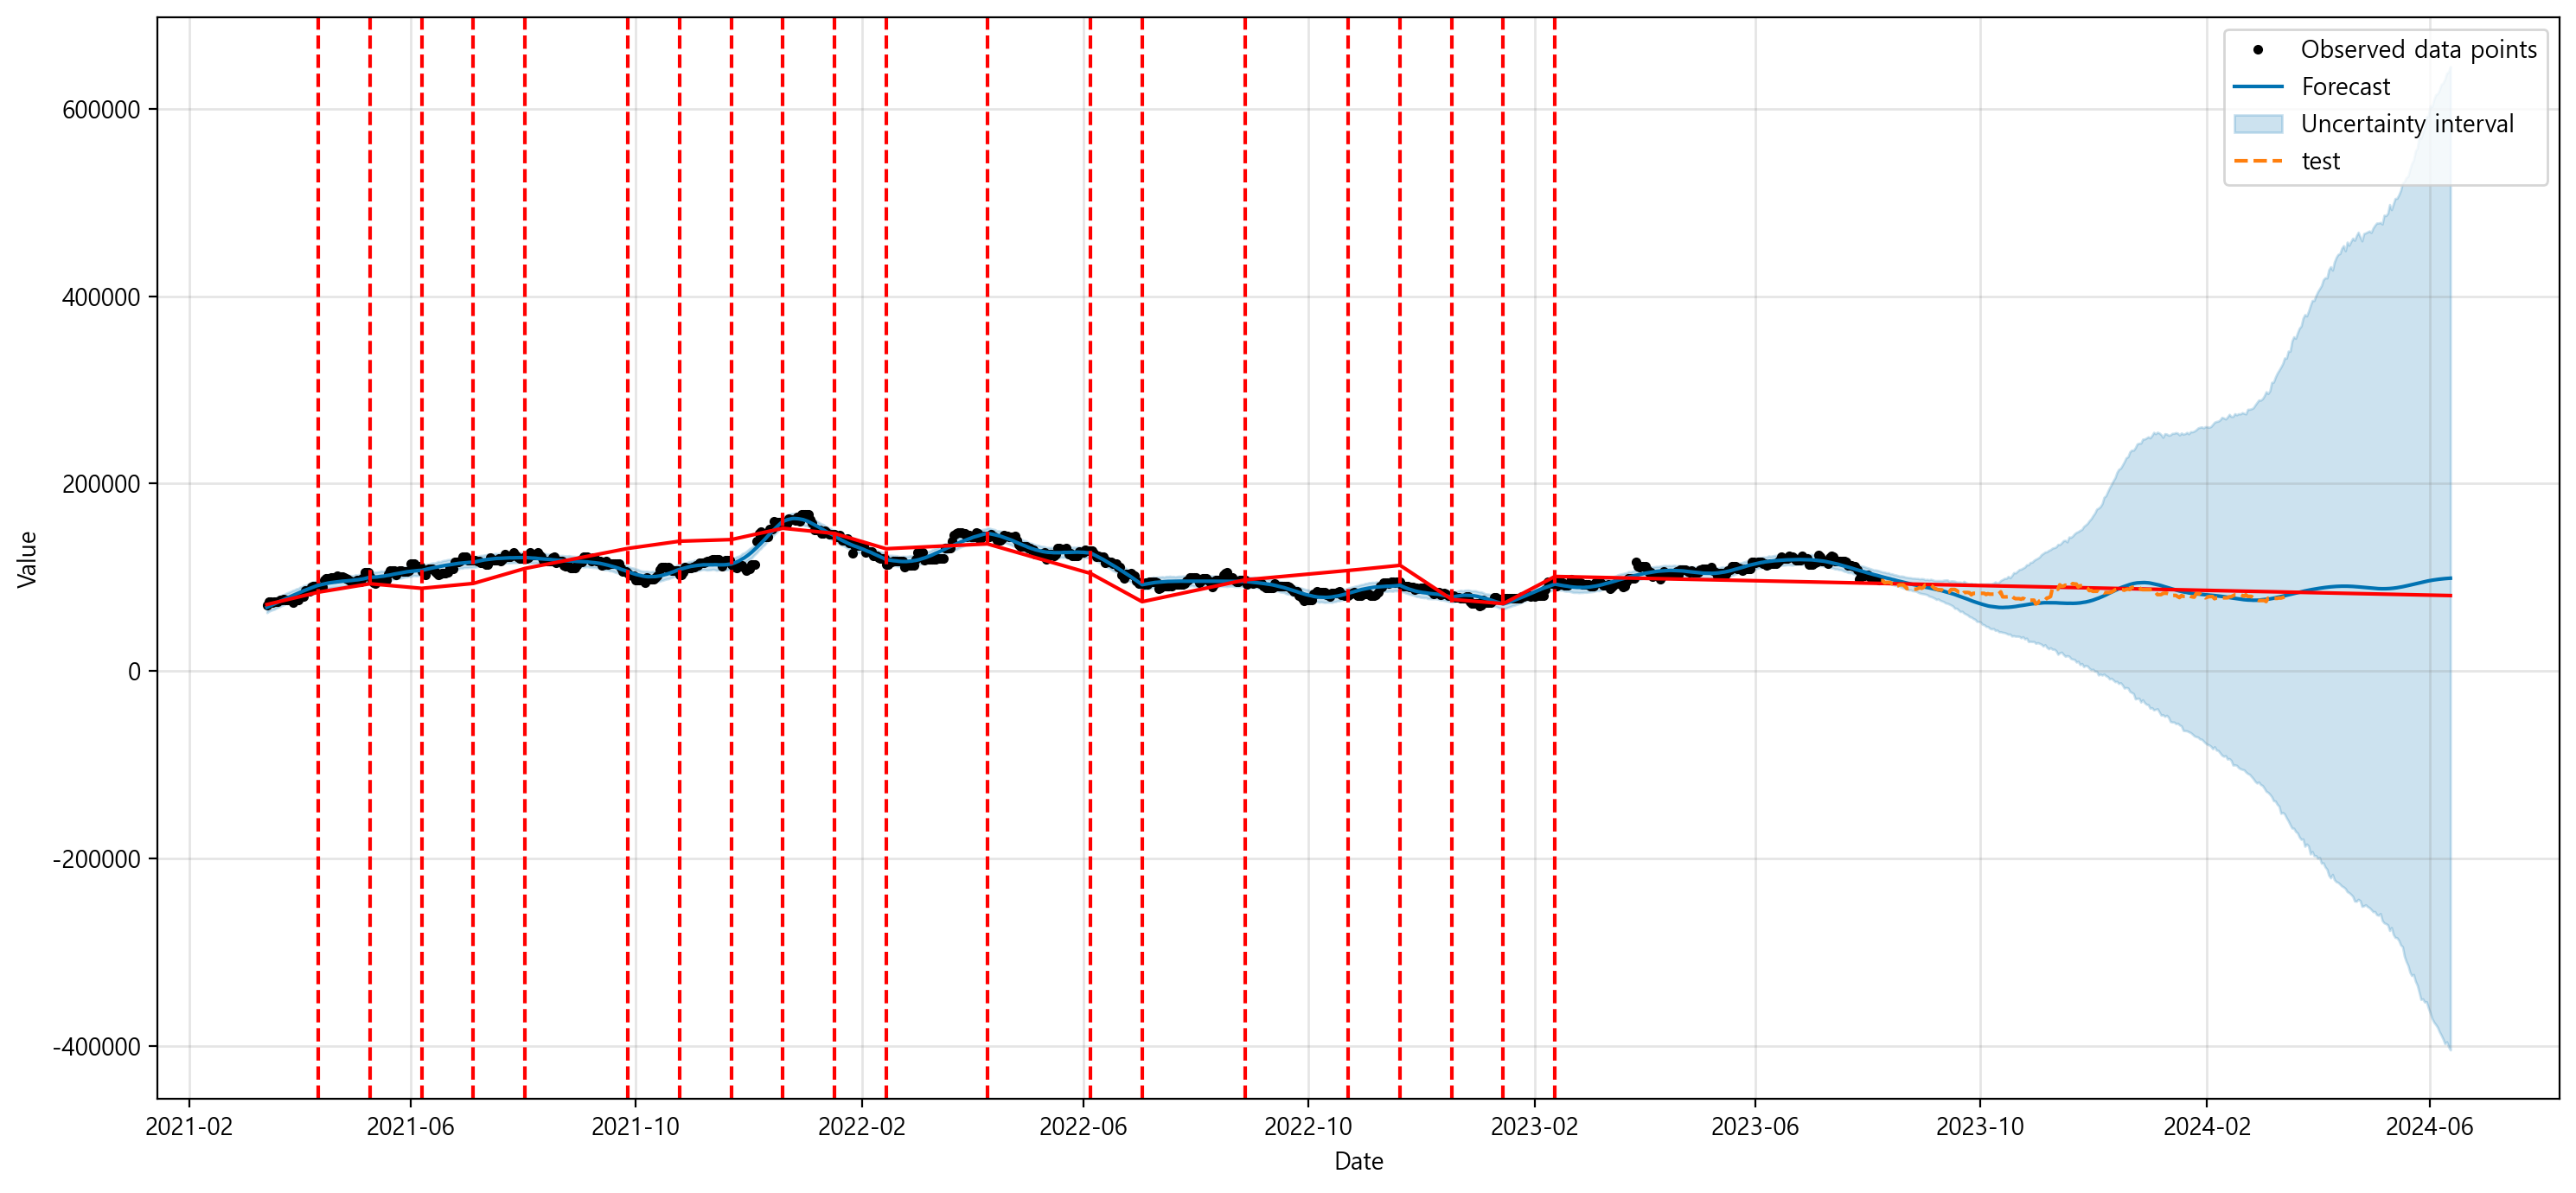

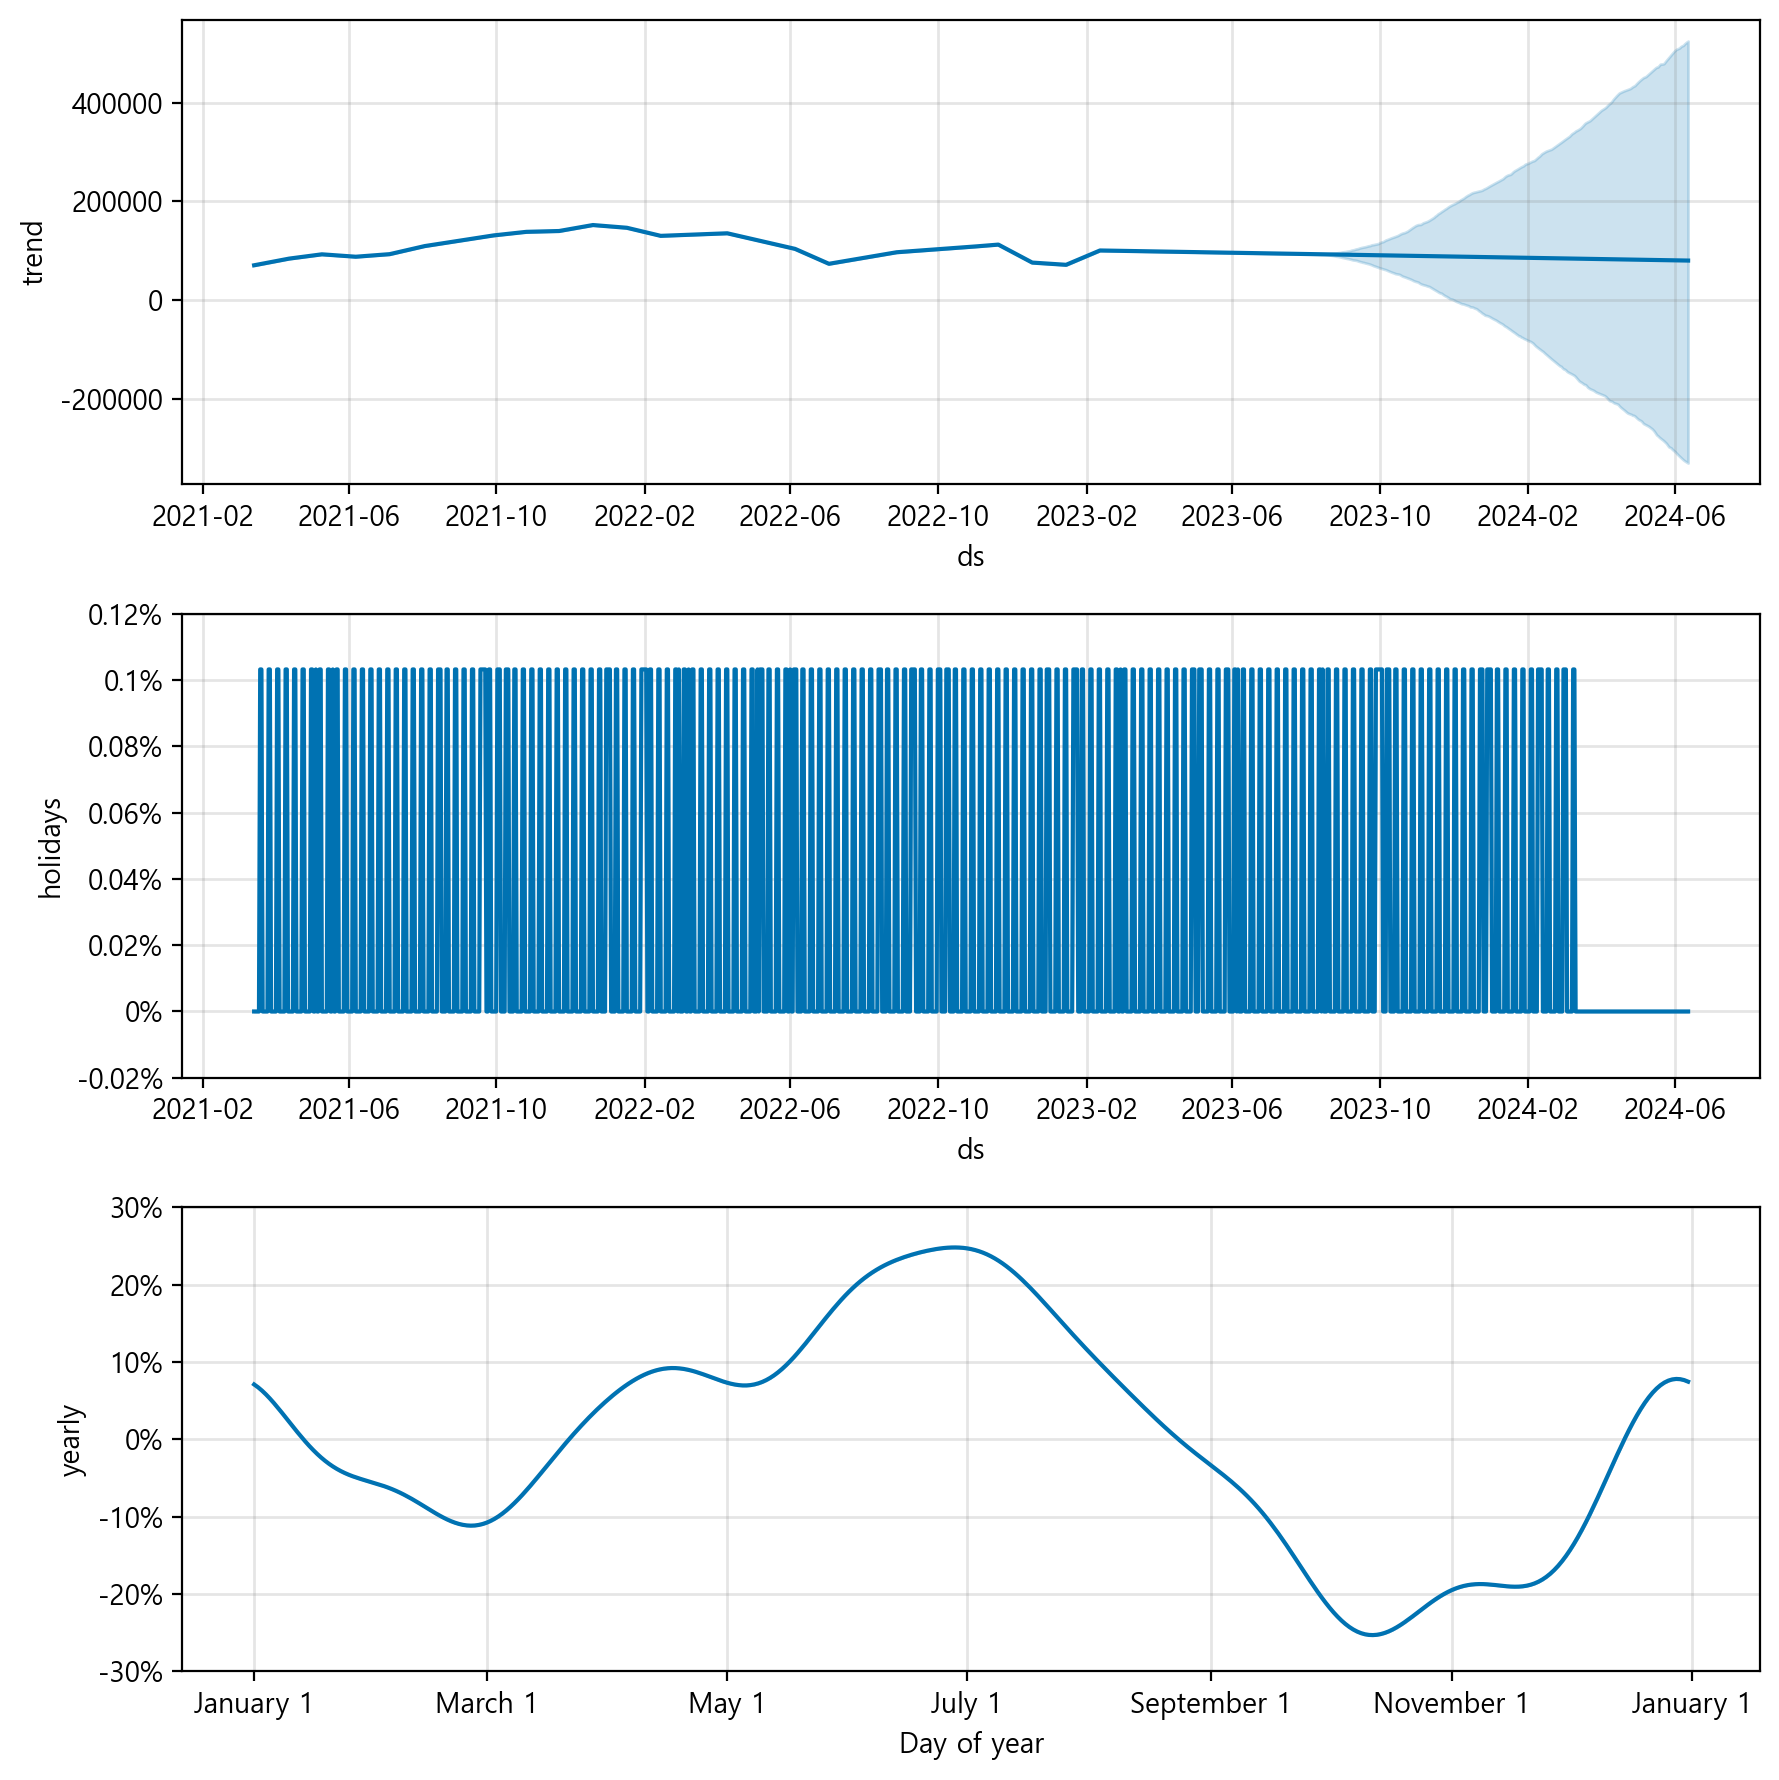

In [140]:
train, test = my_timeseries_split(df4)
model, param, score, forecast, pred = my_prophet(train, test,freq='D', periods= 90, figsize=(15, 7), dpi=200, **params,report=True)